In [ ]:
import os
!pip install pyspark
!pip install -U -q PyDrive
!apt install openjdk-8-jdk-headless -qq
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, TimestampType
from pyspark.sql.functions import col, current_timestamp, to_date, hour, dayofweek

import numpy as np

from itertools import combinations

In [4]:
def create_new_spark_context(appName):
    return SparkSession.builder.appName(appName)\
        .master("local[*]").getOrCreate()


spark_session = create_new_spark_context("LSH")
sc = spark_session.sparkContext


In [5]:
schema = StructType([
    StructField("DEVICE_CODE", IntegerType(), True),
    StructField("SYSTEM_ID", IntegerType(), True),
    StructField("ORIGINE_CAR_KEY", StringType(), True),
    StructField("FINAL_CAR_KEY", StringType(), True),
    StructField("CHECK_STATUS_KEY", IntegerType(), True),
    StructField("COMPANY_ID", StringType(), True),
    StructField("PASS_DAY_TIME", TimestampType(), True)
])

In [6]:
df = spark_session.read.csv(
    '/content/drive/MyDrive/MDA/Project/TrafficData.csv', header=True, schema=schema)


First we remove the outliers from the data. Namely the cars that have been recorded more than 1000 times. We can do this by using the following code:

In [7]:
# add count column to count the number of records, group by FINAL_CAR_KEY
# define a window to count the number of records for each car

from pyspark.sql.window import Window
from pyspark.sql.functions import count

window = Window.partitionBy("FINAL_CAR_KEY")
df = df.withColumn("COUNT", count("*").over(window))

# remove cars with moe than 1000 records
df = df.filter(col("COUNT") < 1000)
df.show(5)


+-----------+---------+---------------+-------------+----------------+----------+-------------------+-----+
|DEVICE_CODE|SYSTEM_ID|ORIGINE_CAR_KEY|FINAL_CAR_KEY|CHECK_STATUS_KEY|COMPANY_ID|      PASS_DAY_TIME|COUNT|
+-----------+---------+---------------+-------------+----------------+----------+-------------------+-----+
|   22010053|      284|       10000007|     10000007|               5|       161|2022-01-12 06:30:27|    1|
|     900233|      283|       10000016|     10000016|               5|       264|2022-01-14 13:57:13|    1|
|     900242|      283|       10000048|     10000048|               5|       264|2022-01-09 21:58:56|    9|
|     101301|       81|       10000048|     10000048|               5|       161|2022-01-09 21:54:31|    9|
|        135|       81|       10000048|     10000048|               5|       161|2022-01-09 21:36:46|    9|
+-----------+---------+---------------+-------------+----------------+----------+-------------------+-----+
only showing top 5 rows



## SDV(Singular Value Decomposition)

In this notebook we are going to perform singular value decomposition on the utility matrix of number of records of each car by each camera. Then analyze the results to see if we can find any interesting patterns, and describe the computed latent factors.

In [8]:
import numpy as np
from pyspark.mllib.linalg import Vectors
from pyspark.mllib.linalg.distributed import RowMatrix

In [21]:
# select DEVICE_CODE, FINAL_CAR_KEY, TIME
df = df.select("FINAL_CAR_KEY", "DEVICE_CODE")

# convert to spark rdd
rdd = df.rdd

In [22]:
rdd.take(1)

[Row(FINAL_CAR_KEY='10000007', DEVICE_CODE=22010053)]

Now we select the cars that have been recorded the most. We can take the top 1000 cars for example. We can do this by using the following code:

In [11]:
# compute the number of records for each car
car_rdd = rdd.map(lambda x: ((x[0], x[1]), 1)).reduceByKey(lambda x, y: x + y)
car_rdd.take(1)

[(('10018941', 22010039), 1)]

In [48]:
# select cars with more than 100 records
car_rdd = car_rdd.filter(lambda x: x[1] > 100)

# get the top 1000 cars with most records
frequent_cars = set(car_rdd.takeOrdered(100000, key=lambda x: -x[1]))

In [19]:
frequent_cars = set([x[0][0] for x in frequent_cars])
frequent_cars

{'10050040',
 '100909240',
 '10198775',
 '10207214',
 '10238599',
 '10263782',
 '10276314',
 '10356457',
 '10507025',
 '10513009',
 '10535705',
 '10681082',
 '10830339',
 '11005855',
 '11242378',
 '11255500',
 '11307102',
 '11343309',
 '11414590',
 '11419059',
 '11481507',
 '11552091',
 '11599300',
 '11634341',
 '11646095',
 '11750659',
 '11980595',
 '12079105',
 '12413790',
 '12448929',
 '12481252',
 '12487357',
 '12655928',
 '12657805',
 '12708152',
 '12923331',
 '13011858',
 '13099714',
 '13187515',
 '13259129',
 '13289707',
 '13345686',
 '13373874',
 '13381887',
 '13411076',
 '13566554',
 '13599570',
 '13606084',
 '13680114',
 '13937238',
 '13980526',
 '14088949',
 '14105787',
 '14596285',
 '14598231',
 '14620104',
 '14671049',
 '14676558',
 '14704577',
 '14793184',
 '14854527',
 '15001630',
 '15010212',
 '15014168',
 '15114679',
 '15147933',
 '15185316',
 '15196348',
 '15262060',
 '15324517',
 '15329356',
 '15481404',
 '15520713',
 '15634488',
 '15643557',
 '15679881',
 '15889916'

In the next step we filter the records using the set of the top 1000 cars. We can do this by using the following code:

In [23]:
# filter the rdd to only contain the top 1000 cars

rdd = rdd.filter(lambda x: x[0] in frequent_cars)

# get number of records grouped by (FINAL_CAR_KEY, DEVICE_CODE)
rdd = rdd.map(lambda x: ((x[0], x[1]), 1)).reduceByKey(lambda x, y: x + y)

First We implement th SVD using pandas dataframes and numpy library.

In [24]:
# create a matrix with (FINAL_CAR_KEY, DEVICE_CODE, COUNT)

rdd = rdd.map(lambda x: (x[0][0], x[0][1], x[1]))

# convert to dataframe
df = rdd.toDF(["FINAL_CAR_KEY", "DEVICE_CODE", "COUNT"])

# group by FINAL_CAR_KEY
df = df.groupBy("FINAL_CAR_KEY").pivot("DEVICE_CODE").sum("COUNT")

In [25]:
# fill null values with 0
df = df.fillna(0)

# convert to numpy array
df = df.toPandas().to_numpy()


In [34]:
# drop the first column
df = df[:, 1:]

In [37]:
matrix = np.float64(df)

In [38]:
# perform svd

U, s, V = np.linalg.svd(matrix, full_matrices=False)

# get the first 200 singular values
s = s[:200]

# get the first 200 columns of U
U = U[:, :200]

# get the first 200 rows of V
V = V[:200, :]

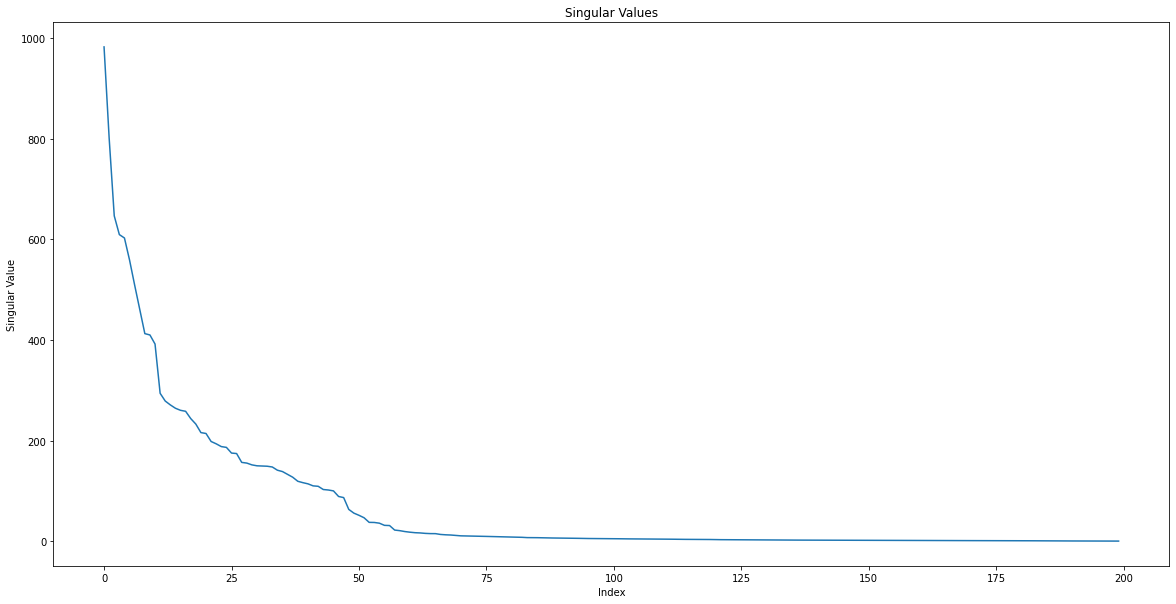

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
sns.lineplot(x=range(200), y=s)
plt.title("Singular Values")
plt.xlabel("Index")
plt.ylabel("Singular Value")
plt.show()
    

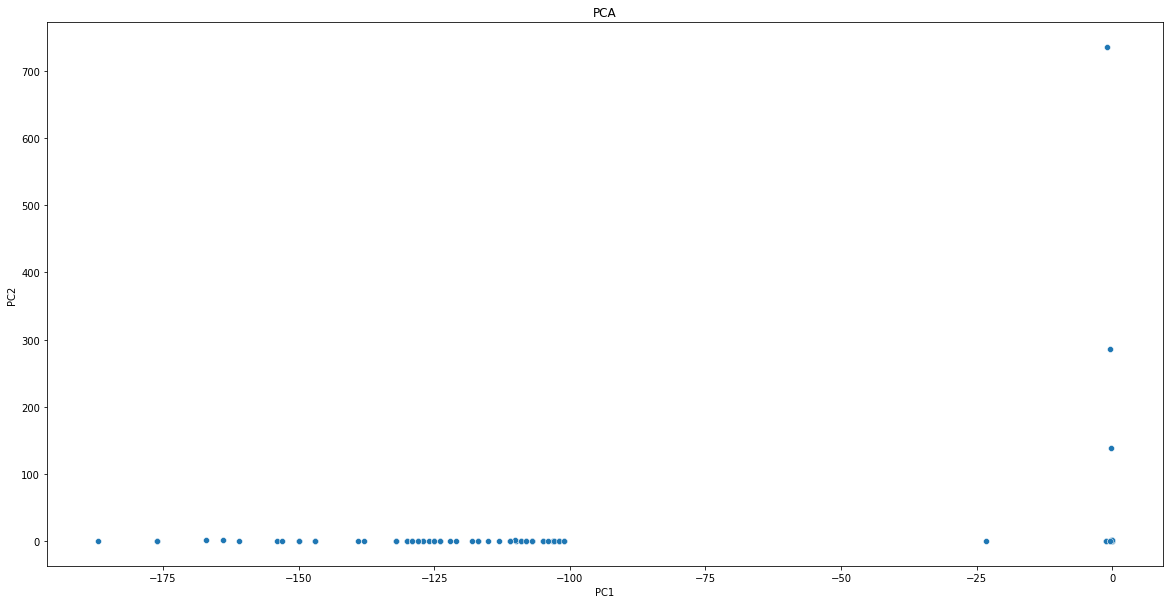

In [42]:
# perform pca on the first 2 singular values and plot the results

# get the first 2 singular values
s2 = s[:2]
# get the first 2 columns of U
U2 = U[:, :2]
# get the first 2 rows of V
V2 = V[:2, :]
# normalize the values
U2 = U2 / np.linalg.norm(U2, axis=0)
V2 = V2 / np.linalg.norm(V2, axis=1)[:, None]

# perform pca
pca = np.matmul(U2, np.diag(s2))

# plot the results
plt.figure(figsize=(20, 10))
sns.scatterplot(x=pca[:, 0], y=pca[:, 1])
plt.title("PCA")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()


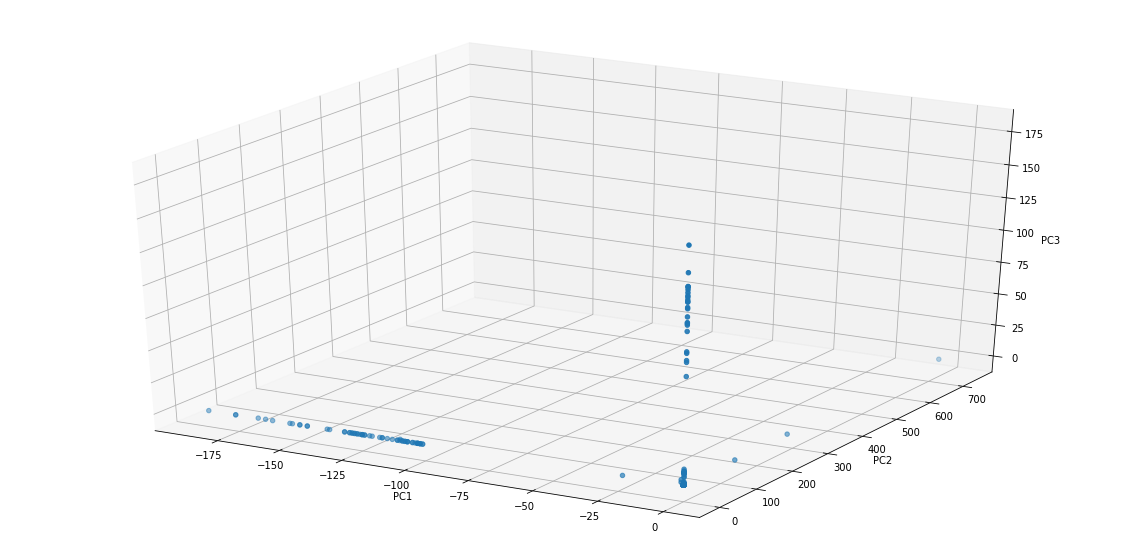

In [44]:
# perform svd on the first 3 singular values and plot the results

# get the first 3 singular values
s3 = s[:3]
# get the first 3 columns of U
U3 = U[:, :3]
# get the first 3 rows of V
V3 = V[:3, :]

# normalize the values
U3 = U3 / np.linalg.norm(U3, axis=0)
V3 = V3 / np.linalg.norm(V3, axis=1)[:, None]

# perform pca
pca = np.matmul(U3, np.diag(s3))

# plot the results
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pca[:, 0], pca[:, 1], pca[:, 2])
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
plt.show()


Now we use the pyspark framework to implement the SVD. To do this, We build a matrix of the form (device, hour, count) and then use the pyspark.mllib.linalg library to compute the SVD. The matrix is built using the following code:

In [64]:
# get the unique device codes
device_codes = rdd.map(lambda x: x[1]).distinct().collect()

In [66]:
# map each device code to a number from 0 to 1000
device_code_map = {}
for i, device_code in enumerate(device_codes):
    device_code_map[device_code] = i

len(device_code_map)

395

In [110]:
# create a CoordinateMatrix

from pyspark.mllib.linalg.distributed import CoordinateMatrix, MatrixEntry

matrix_rdd = rdd.map(lambda x: MatrixEntry(x[0], device_code_map[x[1]], x[2]))
matrix = CoordinateMatrix(matrix_rdd)

# perform svd
svd_result = matrix.toRowMatrix().computeSVD(200, computeU=True)

U = svd_result.U
s = svd_result.s
V = svd_result.V

Now we plot the computed values and factors to see if we can find any interesting patterns.

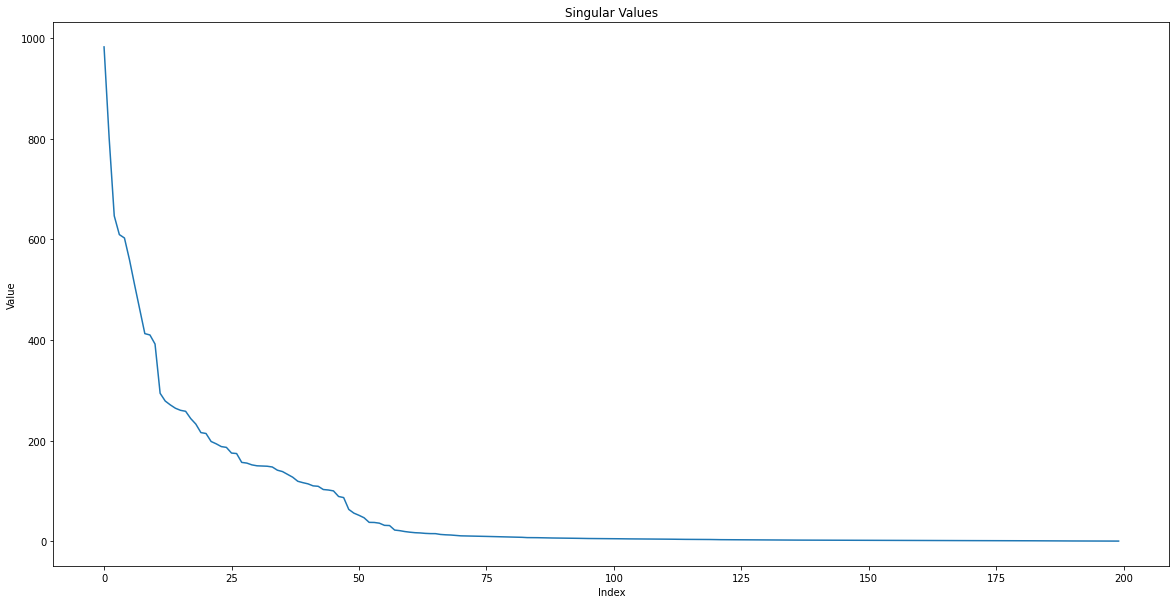

In [109]:
# plot different types of diagrams to visualize the data

import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
# plot the first 10 singular values
plt.plot(s[:200])
# set the title, x and y labels
plt.title("Singular Values")
plt.xlabel("Index")
plt.ylabel("Value")
plt.show()

In [111]:
# convert U from RowMatrix to numpy.ndarray
U = U.rows.collect()
U = np.array([x.toArray() for x in U])

# convert V from DenseMatrix to numpy.ndarray
V = V.toArray()

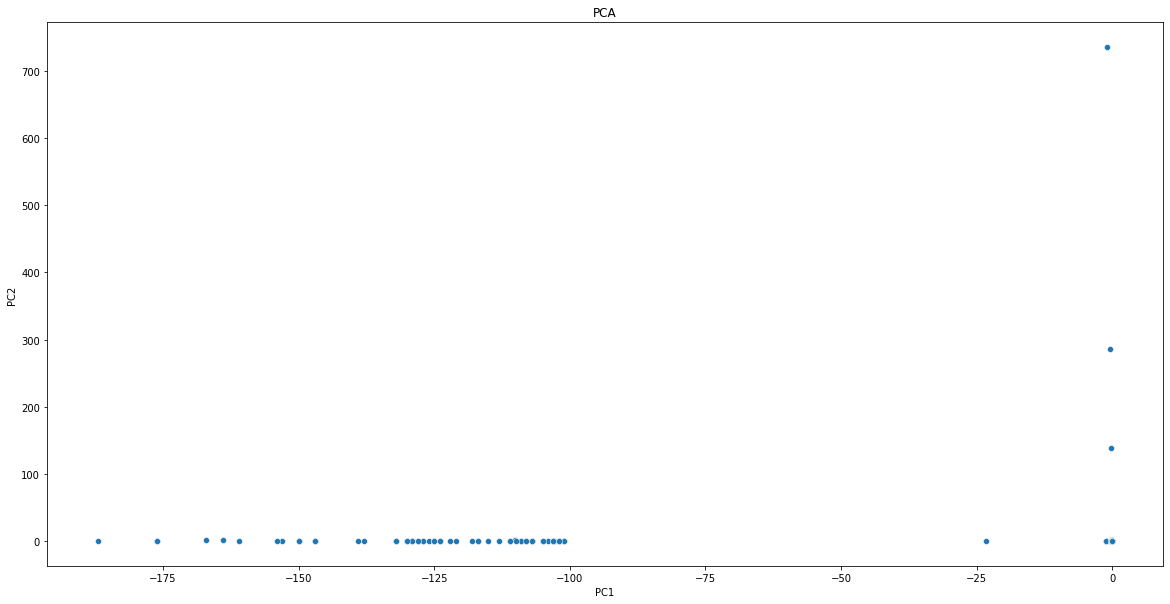

In [107]:
# perform pca on the first 2 singular values and plot the results

# get the first 2 singular values
s2 = s[:2]
# get the first 2 columns of U
U2 = U[:, :2]
# get the first 2 rows of V
V2 = V[:2, :]

# normalize the values
U2 = U2 / np.linalg.norm(U2, axis=0)
V2 = V2 / np.linalg.norm(V2, axis=1)[:, None]

# perform pca
pca = np.matmul(U2, np.diag(s2))

# plot the results, color the points based on the car_id
plt.figure(figsize=(20, 10))
sns.scatterplot(x=pca[:, 0], y=-pca[:, 1])
plt.title("PCA")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()


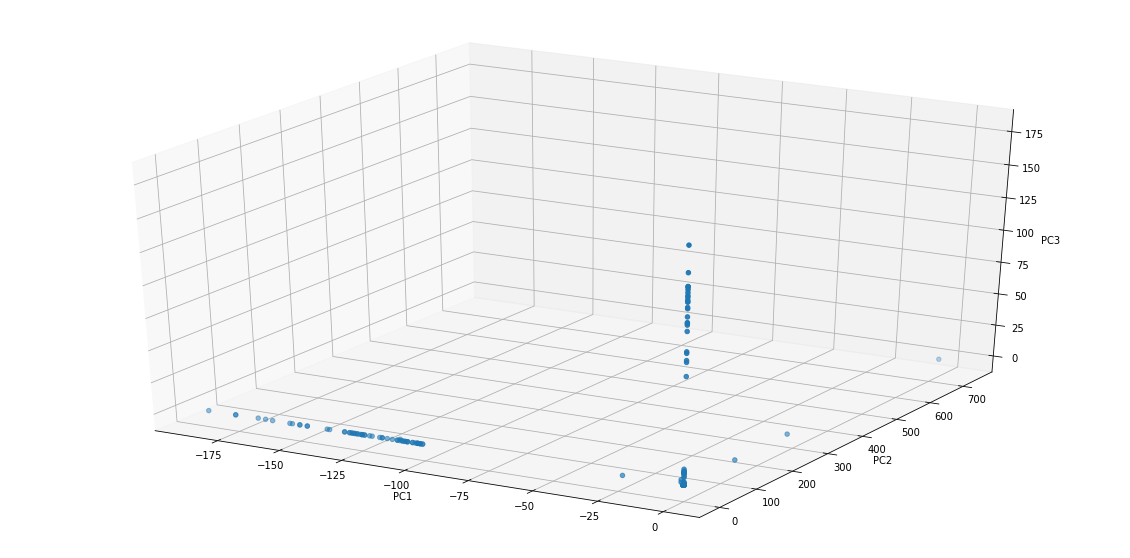

In [114]:
# perform svd on the first 3 singular values and plot the results

# get the first 3 singular values
s3 = s[:3]
# get the first 3 columns of U
U3 = U[:, :3]
# get the first 3 rows of V
V3 = V[:3, :]

# normalize the values
U3 = U3 / np.linalg.norm(U3, axis=0)
V3 = V3 / np.linalg.norm(V3, axis=1)[:, None]

# perform pca
pca = np.matmul(U3, np.diag(s3))

# plot the results
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pca[:, 0], -pca[:, 1], pca[:, 2])
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
plt.show()